# 0.3.0 Projecting and transforming geometries

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px

import contextily

import geopandas as gpd 
from shapely.geometry import Point, Polygon

import mapclassify

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

In [4]:
import sys
sys.path.append("../../") 

import utils.paths as path
from utils.paths2 import direcciones

In [5]:
districts = gpd.read_file(path.data_raw_dir("working/paris_districts_utm.geojson"))
districts.geometry = districts.geometry.to_crs(epsg = 4326)
districts.head()

,id,district_name,population,geometry
0,1,St-Germain-l'Auxerrois,1672,"POLYGON ((2.34459 48.85405, 2.34459 48.85405, ..."
1,2,Halles,8984,"POLYGON ((2.34937 48.86058, 2.34822 48.85852, ..."
2,3,Palais-Royal,3195,"POLYGON ((2.33947 48.86214, 2.33912 48.86148, ..."
3,4,Place-Vendôme,3044,"POLYGON ((2.33194 48.86491, 2.33135 48.86399, ..."
4,5,Gaillon,1345,"POLYGON ((2.33632 48.86797, 2.33587 48.86700, ..."


## 0.3.2 Geographic vs projected coordinates

In [6]:
# Print the CRS information
print(districts.crs)

# Print the first rows of the GeoDataFrame
print(districts.head())

epsg:4326
   id           district_name  population  \
0   1  St-Germain-l'Auxerrois        1672   
1   2                  Halles        8984   
2   3            Palais-Royal        3195   
3   4           Place-Vendôme        3044   
4   5                 Gaillon        1345   

                                            geometry  
0  POLYGON ((2.34459 48.85405, 2.34459 48.85405, ...  
1  POLYGON ((2.34937 48.86058, 2.34822 48.85852, ...  
2  POLYGON ((2.33947 48.86214, 2.33912 48.86148, ...  
3  POLYGON ((2.33194 48.86491, 2.33135 48.86399, ...  
4  POLYGON ((2.33632 48.86797, 2.33587 48.86700, ...  


## 0.3.3 Projecting a GeoDataFrame

In [7]:
# Print the CRS information
print(districts.crs)

epsg:4326


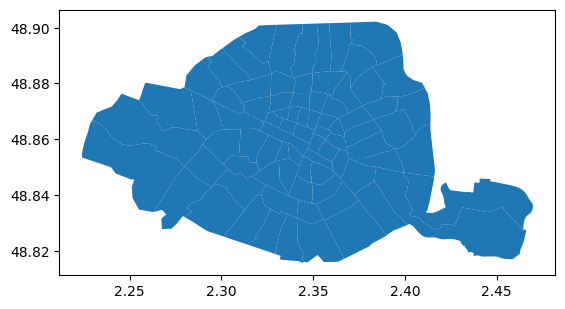

In [8]:
# Plot the districts dataset
districts.plot()
plt.show()

In [9]:
# Convert the districts to the RGF93 reference system
districts_RGF93 = districts.to_crs(epsg=2154)

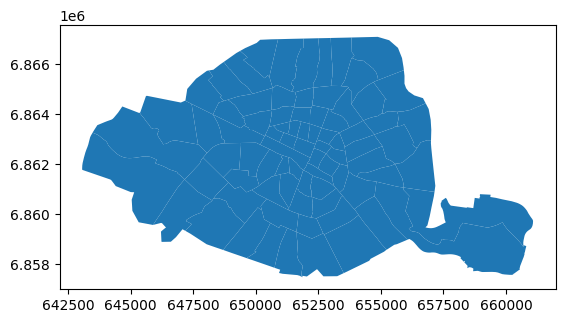

In [10]:
# Plot the districts dataset again
districts_RGF93.plot()
plt.show()

## 0.3.4 Projecting a Point

In [11]:
eiffel_tower = Point(2.2945, 48.8584)

In [12]:
# Put the point in a GeoSeries with the correct CRS
s_eiffel_tower = gpd.GeoSeries([eiffel_tower], crs={'init': 'epsg:4326'})

In [13]:
# Convert to other CRS
s_eiffel_tower_projected = s_eiffel_tower.to_crs(epsg=2154)

In [14]:
# Print the projected point
print(s_eiffel_tower_projected)

0    POINT (648237.302 6862271.682)
dtype: geometry


## 0.3.5 Calculating distance in a projected CRS

In [15]:
# Extract the single Point
eiffel_tower = s_eiffel_tower_projected[0]

In [16]:
# Read the restaurants csv file into a DataFrame
df = pd.read_csv(path.data_raw_dir("working/paris_restaurants.csv"))

# Convert it to a GeoDataFrame
restaurants = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y), crs="EPSG:3857")

In [17]:
# Ensure the restaurants use the same CRS
restaurants = restaurants.to_crs(s_eiffel_tower_projected.crs)

In [18]:
# The distance from each restaurant to the Eiffel Tower
dist_eiffel = restaurants.distance(eiffel_tower)

In [19]:
# The distance to the closest restaurant
print(dist_eiffel.min())

303.5625538786418


## 0.3.6 Projecting to Web Mercator for using web tiles

In [20]:
# Convert to the Web Mercator projection
restaurants_webmercator = restaurants.to_crs(epsg=3857)

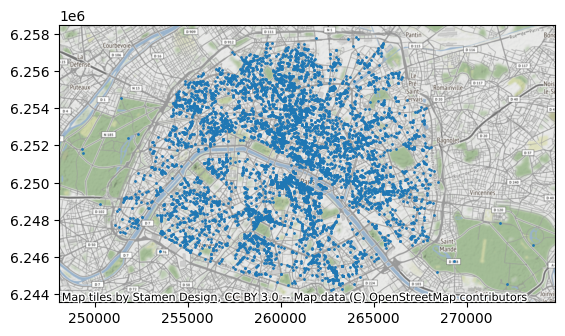

In [21]:
# Plot the restaurants with a background map
ax = restaurants_webmercator.plot(markersize = 1)
contextily.add_basemap(ax)
plt.show()

## 0.3.6 Exploring a Land Use dataset

https://land.copernicus.eu/local/urban-atlas

In [29]:
land_use = gpd.read_file(path.data_raw_dir("working/FR001L1_PARIS_UA2018_v013.gpkg"))
land_use.geometry = land_use.geometry.to_crs(epsg = 4326)

land_use = land_use.loc[:,['class_2018','geometry']]
land_use.rename(columns={'class_2018':'class'}, inplace=True)

land_use.head()

,class,geometry
0,Discontinuous medium density urban fabric (S.L...,"MULTIPOLYGON (((2.46079 48.65060, 2.46079 48.6..."
1,Discontinuous dense urban fabric (S.L. : 50% -...,"MULTIPOLYGON (((2.18463 48.49043, 2.18463 48.4..."
2,Discontinuous dense urban fabric (S.L. : 50% -...,"MULTIPOLYGON (((2.29310 48.56009, 2.29257 48.5..."
3,Discontinuous dense urban fabric (S.L. : 50% -...,"MULTIPOLYGON (((2.26731 48.59829, 2.26731 48.5..."
4,Continuous urban fabric (S.L. : > 80%),"MULTIPOLYGON (((2.59037 48.62076, 2.59032 48.6..."


In [30]:
print(land_use.shape)

(156314, 2)


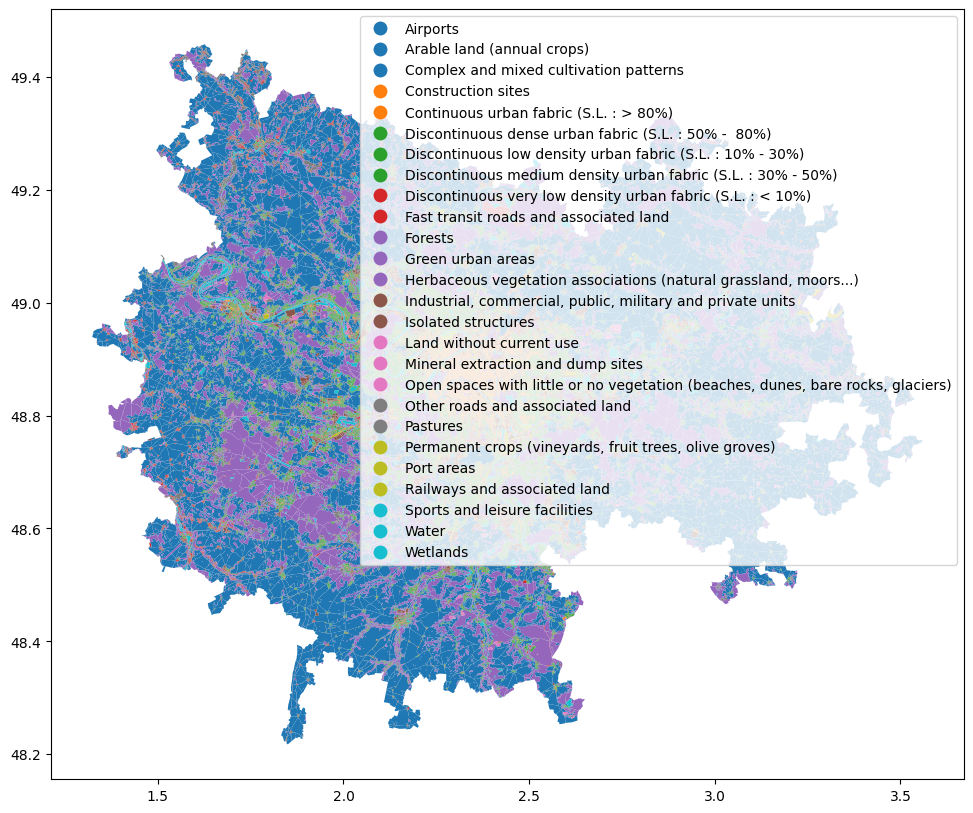

In [31]:
# Make a plot of the land use with 'class' as the color
land_use.plot(column='class', legend=True, figsize=(15, 10))
plt.show()

In [32]:
# Add the area as a new column
land_use['area'] = land_use.area

In [33]:
# Calculate the total area for each land use class
total_area = land_use.groupby('class')['area'].sum() / 1000**2
print(total_area)

class
Airports                                                                           8.535054e-09
Arable land (annual crops)                                                         7.537061e-07
Complex and mixed cultivation patterns                                             9.541302e-11
Construction sites                                                                 1.601324e-09
Continuous urban fabric (S.L. : > 80%)                                             2.725643e-08
Discontinuous dense urban fabric (S.L. : 50% -  80%)                               6.613119e-08
Discontinuous low density urban fabric (S.L. : 10% - 30%)                          1.847202e-08
Discontinuous medium density urban fabric (S.L. : 30% - 50%)                       3.869253e-08
Discontinuous very low density urban fabric (S.L. : < 10%)                         1.620922e-08
Fast transit roads and associated land                                             4.229927e-09
Forests                           

## 0.3.7 Intersection of two polygons

In [ ]:
# # Plot the two polygons
# geopandas.GeoSeries([park_boulogne, muette]).plot(alpha=0.5, color=['green', 'blue'])
# plt.show()

# # Calculate the intersection of both polygons
# intersection = park_boulogne.intersection(muette)

# # Plot the intersection
# geopandas.GeoSeries([intersection]).plot()
# plt.show()

# # Print proportion of district area that occupied park
# print(intersection.area / muette.area)

## 0.3.8 Intersecting a GeoDataFrame with a Polygon

In [ ]:
# # Print the land use datset and Notre-Dame district polygon
# print(land_use.head())
# print(type(muette))

# # Calculate the intersection of the land use polygons with Notre Dame
# land_use_muette = land_use.geometry.intersection(muette)

# # Plot the intersection
# land_use_muette.plot(edgecolor='black')
# plt.show()

# # Print the first five rows of the intersection
# print(land_use_muette.head())

## 0.3.10 Overlay of two polygon layers

In [ ]:
# # Print the first five rows of both datasets
# print(land_use.head())
# print(districts.head())

# # Overlay both datasets based on the intersection
# combined = geopandas.overlay(land_use, districts,
# how='intersection')

# # Print the first five rows of the result
# print(combined.head())

## 0.3.11 Inspecting the overlay result

In [ ]:
# # Print the first rows of the overlay result
# print(combined.head())

# # Add the area as a column
# combined['area'] = combined.area

# # Take a subset for the Muette district
# land_use_muette = combined[combined['district_name'] == 'Muette']

# # Visualize the land use of the Muette district
# land_use_muette.plot(column='class')
# plt.show()

# # Calculate the total area for each land use class
# print(land_use_muette.groupby('class')['area'].sum() / 1000**2)


In [23]:
print('ok_')

ok_
